In [115]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [116]:
# Import the train data
data = pd.read_csv('train.csv')
data

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [117]:
# Convert date from object to datetime
data['date'] = pd.to_datetime(data['date'])
# extract the numbers from the datetime
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data = data.drop('date',axis=1)

# Modify the data made by caracters

label_encoder = LabelEncoder()

data['country'] = label_encoder.fit_transform(data['country'])
data['store'] = label_encoder.fit_transform(data['store'])
data['product'] = label_encoder.fit_transform(data['product'])

# Replace Nan for 0

data['num_sold'] = data['num_sold'].fillna(0)
data['num_sold'] = data.pop('num_sold')
print(data)

# Normalization

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)
print(data)

            id  country  store  product  year  month  day  num_sold
0            0        0      0        0  2010      1    1       0.0
1            1        0      0        1  2010      1    1     973.0
2            2        0      0        2  2010      1    1     906.0
3            3        0      0        3  2010      1    1     423.0
4            4        0      0        4  2010      1    1     491.0
...        ...      ...    ...      ...   ...    ...  ...       ...
230125  230125        5      1        0  2016     12   31     466.0
230126  230126        5      1        1  2016     12   31    2907.0
230127  230127        5      1        2  2016     12   31    2299.0
230128  230128        5      1        3  2016     12   31    1242.0
230129  230129        5      1        4  2016     12   31    1622.0

[230130 rows x 8 columns]
[[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.99999131 -1.         -1.         ... -1.         -1.
  -0.67233541]
 [-0.999982

In [118]:
def split_data(data_x,data_y):
    from sklearn.model_selection import train_test_split
    x_train,x_temp,y_train,y_temp = train_test_split(data_x,
                                                    data_y,test_size=0.3,random_state=42)
    x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,random_state=42)
    dict_var = {'train':[x_train,y_train],
                'test':[x_test,y_test],
                'validation':[x_val,y_val]}
    return dict_var



NEURAL NETWORK

In [119]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)


# Neural Network modelisation

def train_neural_model(data,x_train,y_train,val_input,val_output):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(len(data.drop('num_sold',axis=1).columns),)))
    model.add(Dense(40,activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(Dense(70,activation='elu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(30,activation='elu'))
    model.add(Dense(1,activation='linear'))

    print(model.summary())

    model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy','mse'])

    history = model.fit(x_train,y_train,batch_size=80,epochs=70,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))
    
    return model, history

# Validation of model performance with new data

def pred_val(model,x_test,y_test):
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)

    print(f'mean squared error prediction: {mse:.4f}')
    print(f'mean absolute error prediction: {mae:.4f}')

    return mse,mae
    # accuracy_tol = 0.1

    # print('accuracy of the model = ',accuracy_score(y_test,prediction))

FUNCTIONS TO MAKE LSTM NEURAL NETWORK

In [120]:
# LSTM Model

def create_dataset_LSTM(dataset,lookback):
    dataX = []
    dataY = []
    for i in range(len(dataset)-lookback):
        dataX.append(dataset[i:i+lookback,:-1])
        dataY.append(dataset[i+lookback,-1])

    return np.array(dataX), np.array(dataY)

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)


def lstm_model(dict_var,lookback):
    from keras import models
    from keras.layers import Dense,Dropout
    import tensorflow as tf
    from keras.layers import LSTM

    # Architecture of the model
    model = models.Sequential()
    model.add(LSTM(40,activation='relu',return_sequences=True,
                   input_shape=(lookback,dict_var['train'][0].shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(70,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='linear'))

    # Compile the model
    model.compile(loss='mse',optimizer='adam',metrics=['mse','mae'])
    print(model.summary())
    # Fit the model to the training data
    history = model.fit(dict_var['train'][0],dict_var['train'][1],batch_size=70,epochs=40,
                        shuffle=True,callbacks=my_lr_scheduler,
                        validation_data=(dict_var['validation'][0],
                                         dict_var['validation'][1]))

    return model, history

def lstm_predict(model,dict_var):
    from sklearn.metrics import mean_absolute_error,mean_squared_error
    y_pred = model.predict(dict_var['test'][0])
    mae_pred = mean_absolute_error(dict_var['test'][1],y_pred)
    mse_pred = mean_squared_error(dict_var['test'][1],y_pred)
    
    print(f'mean squared error prediction: {mse_pred:.4f}')
    print(f'mean absolute error prediction: {mae_pred:.4f}')

    return mae_pred,mse_pred

def lstm_graph(model,history):
    # Plot the loss function of the neural network

    import matplotlib.pyplot as plt

    # plot fonction perte

    loss=history.history['loss']

    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure(figsize=(12,6))


    plt.subplot(1,2,1)
    plt.plot(epochs, loss, 'bo', label = 'Training')
    plt.plot(epochs, val_loss, 'b', label='Validation')
    plt.title('Loss during the training and validation')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot metrics of the model

    mae_neural = history.history['mae']
    val_mae = history.history['val_mae']

    plt.subplot(1,2,2)
    plt.plot(epochs,mae_neural,'bo',label='Training')
    plt.plot(epochs, val_mae, 'b', label='Validation')
    plt.title('mae during the training and validation')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    # plt.savefig('loss_accuracy_model.jpg')
    plt.show()

EXECUTE LSTM NEURAL NETWORK MODEL

verify that the shape of the entry is effectively (samples,timestep,features)

The shape of the entry is: (230125, 5, 7)
The shape of the target is: (230125,)


/Users/sergioarias/Desktop/Environments/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 5, 40)          │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 70)             │        31,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 30)             │         2,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,921 (159.85 KB)

 Trainable params: 40,921 (159.85 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0511 - mae: 0.1617 - mse: 0.0511 - val_loss: 0.0031 - val_mae: 0.0383 - val_mse: 0.0031 - learning_rate: 0.0010
Epoch 2/40
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0061 - mae: 0.0586 - mse: 0.0061 - val_loss: 0.0025 - val_mae: 0.0369 - val_mse: 0.0025 - learning_rate: 0.0010
Epoch 3/40
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0043 - mae: 0.0463 - mse: 0.0043 - val_loss: 0.0020 - val_mae: 0.0289 - val_mse: 0.0020 - learning_rate: 0.0010
Epoch 4/40
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0038 - mae: 0.0428 - mse: 0.0038 - val_loss: 0.0021 - val_mae: 0.0276 - val_mse: 0.0021 - learning_rate: 0.0010
Epoch 5/40
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0036 - mae: 0.0412 - mse: 0.0036 - val_loss: 0.0018 - val_mae: 0.0259 - val_mse: 0.0018 - learning_rate: 0.0010
Epoch 6/40
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0034 - mae: 0.0402 - mse: 0.0034 - val_loss: 0.001

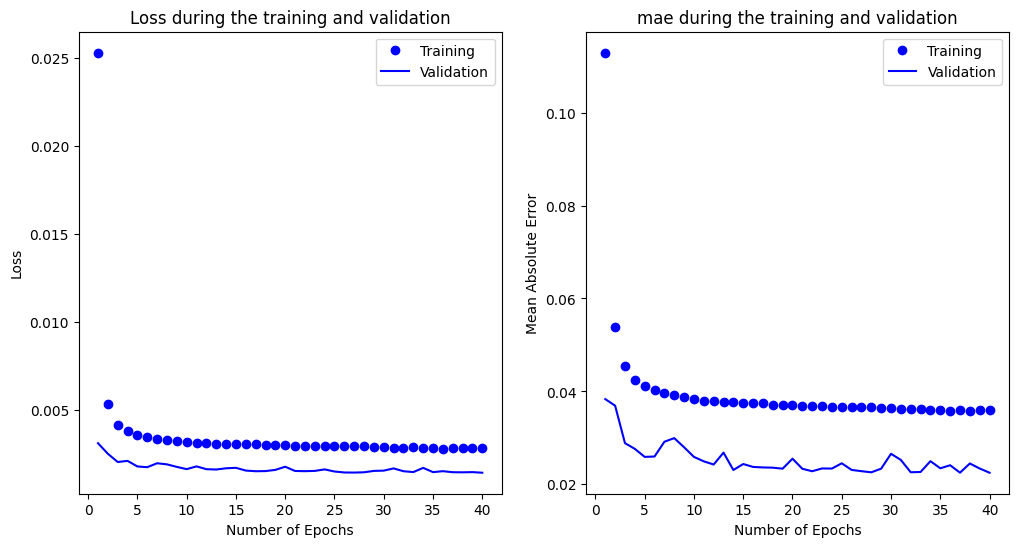

In [121]:
# TEST OF THE CODE

lookback = 5

dataX,dataY = create_dataset_LSTM(data,lookback)

print('verify that the shape of the entry is effectively (samples,timestep,features)\n')
print(f'The shape of the entry is: {dataX.shape}')
print(f'The shape of the target is: {dataY.shape}')

# # reshape dataX that will enter to the model (if necessary)

# dataX = dataX.reshape(-1,dataX[1],1)

# split data

dict_var = split_data(dataX,dataY)

# run the model LSTM
model, history = lstm_model(dict_var,lookback)

# Graph of training and validation results
lstm_graph(model,history)


In [122]:
# Prediction of the test values with LSTM neural network

lstm_mae_pred,lstm_mse_pred = lstm_predict(model,dict_var)

1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step
mean squared error prediction: 0.0014
mean absolute error prediction: 0.0225


LAUNCH THE CODE FOR BASIC NEURAL NETWORK (IT DOESN'T WORK VERY WELL)

In [ ]:
# # split the data to train, test and validation
# dict_var = split_data(data)

# # Train the neural network model
# model, history = train_neural_model(data,dict_var['train'][0],
#                            dict_var['train'][1],
#                            dict_var['validation'][0],
#                            dict_var['validation'][1])

# # Make the prediction and verify mean squared error and mean absolute error
# mse,mae = pred_val(model,dict_var['test'][0],
#                    dict_var['test'][1])

# lstm_graph(model,history)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 40)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 70)             │         2,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 30)             │         2,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,351 (20.90 KB)

 Trainable params: 5,351 (20.90 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 762us/step - accuracy: 0.0000e+00 - loss: 585554.3125 - mse: 585554.3125 - val_accuracy: 0.0000e+00 - val_loss: 480089.0312 - val_mse: 480089.0312 - learning_rate: 0.0010
Epoch 2/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 473666.2500 - mse: 473666.2500 - val_accuracy: 0.0000e+00 - val_loss: 479677.4062 - val_mse: 479677.4062 - learning_rate: 0.0010
Epoch 3/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 740us/step - accuracy: 0.0000e+00 - loss: 477348.2188 - mse: 477348.2188 - val_accuracy: 0.0000e+00 - val_loss: 479578.0000 - val_mse: 479578.0000 - learning_rate: 0.0010
Epoch 4/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.0000e+00 - loss: 475031.7812 - mse: 475031.7812 - val_accuracy: 0.0000e+00 - val_loss: 479490.5000 - val_mse: 479490.5000 - learning_rate: 0.0010
Epoch 5/150
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.0000e+00 - loss: 477801.3125 - mse: 477801.3125 - val_accu